# Python Function for Stock Breakouts Backtester

Prepared by Marvin Rubia ([My LinkedIn](https://www.linkedin.com/in/marvinrubia08/))

## Install yahoo-fin library

In [4]:
!pip install yahoo-fin seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 7.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 80.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.9/303.9 kB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 63.9 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 130.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 35.3 MB/s eta 0:00:00


## Code the breakout backtesting function

In [39]:
def breakout_profitability(ticker):
  '''A function that returns a histogram and probabilistic information for all breakouts of a stock using its historical daily prices'''

  # Import libraries
  from yahoo_fin.stock_info import get_data
  import pandas as pd
  import numpy as np
  import seaborn as sns
  import matplotlib.pyplot as plt
  from datetime import datetime, timedelta  # Import the datetime module

  ## PREPARE OUR DATAFRAME FOR ANALYSIS
  # Get the historical weekly prices from the specified start date and end date (both YYYY-mm-dd)
  # Calculate the end date (today's date)
  end_date = datetime.now().strftime('%Y-%m-%d')

  # Calculate the start date (5 years ago from today)
  start_date = (datetime.now() - timedelta(days=1825)).strftime('%Y-%m-%d')  # 1825 days in 5 years

  # Retrieve historical price data for the specified stock ticker and date range
  hist = get_data(ticker, start_date=start_date, end_date=end_date, index_as_date=False)

  print(f"Retrieved {len(hist)} days of historical prices for {ticker.upper()}")

  # Drop the adjusted close column
  prices = hist.drop(['adjclose'], axis=1)

  # Get the selling pressure, which is distance between high and close
  prices['SellingPressure'] = prices['high'] - prices['close']

  # Get the length of candle's body (from open to close)
  prices['O-to-C'] = prices['close'] - prices['open']

  # Get the rolling mean of the candle's body for recent 20 candles
  prices['OC-20D-Mean'] = prices['O-to-C'].rolling(20).mean()

  # Get the % increase or decrease of the current body length from the rolling mean
  prices['OC-%-from-20D-Mean'] = 100*(prices['O-to-C'] - prices['OC-20D-Mean'])/prices['OC-20D-Mean']

  # Get the maximum OC compared to the recent 10 candles
  prices['MaxOC_Prev10'] = prices['O-to-C'].rolling(10).max()

  # Get the rolling mean of volume for the recent 20 candles
  prices['Volume-20D-Mean'] = prices['volume'].rolling(20).mean()

  # Get the % increase or decrease of the current volume from the rolling mean
  prices['Volume-%-from-20D-Mean'] = 100*(prices['volume'] - prices['Volume-20D-Mean'])/prices['Volume-20D-Mean']

  # Drop the null values for the first 19 rows, where no mean can be computed yet.
  prices = prices.dropna()

  # Rearrange columns
  prices = prices[['ticker', 'date', 'open', 'high', 'low', 'close',
                   'O-to-C', 'OC-20D-Mean', 'volume', 'Volume-20D-Mean',
                   'MaxOC_Prev10', 'SellingPressure', 'OC-%-from-20D-Mean',
                   'Volume-%-from-20D-Mean',
                  ]]

  # Select the subset of dataframe where breakout conditions apply
  # Conditions: 1. green candle, 2. candle's body is longest in 10 days,
  # 3. breakout volume is 50% higher than the rolling 20-day average, and
  # 4. breakout candle has body that is 100% higher than the rolling 20-day average

  condition = (prices['O-to-C'] > 0.0) & (prices['O-to-C'] == prices['MaxOC_Prev10']) & (prices['OC-%-from-20D-Mean'] >= 100.0) & (prices['SellingPressure']/prices['O-to-C'] <= 0.40) & (prices['Volume-%-from-20D-Mean'] >= 50.0)

  breakouts = prices[condition]

  ## GET THE PROFIT (OR LOSS) PER CANDLE
  # Get the index (from the dataframe) of each breakout row, which is necessary for looping later
  breakouts_indices = breakouts.index.tolist()

  profits = []
  for index in breakouts_indices:
    # For a given breakout candle index, slice the historical prices dataframe 10 rows RIGHT AFTER the breakout row
    ten_rows_after_a_breakout = prices.iloc[index+1:index+11]

    # Compute the highest price within the next 10 days RIGHT AFTER the breakout candle
    highest_price_within10days = ten_rows_after_a_breakout['high'].max()

    # Compute the lowest price within the next 10 days RIGHT AFTER the breakout candle
    lowest_price_within10days = ten_rows_after_a_breakout['low'].min()

    # Get the row index corresponding for the highest_price_within10days
    # Check if there are any rows that meet the condition
    if not ten_rows_after_a_breakout.empty:
        highest_price_index = ten_rows_after_a_breakout[ten_rows_after_a_breakout['high'] == highest_price_within10days].index[0]
    else:
        # Handle the case where there are no matching rows
        highest_price_index = None  # You can assign a default value or handle it as needed


    # Get the row index corresponding for the lowest_price_within10days
    # Check if there are any rows that meet the condition
    if not ten_rows_after_a_breakout.empty:
        lowest_price_index = ten_rows_after_a_breakout[ten_rows_after_a_breakout['low'] == lowest_price_within10days].index[0]
    else:
        # Handle the case where there are no matching rows
        lowest_price_index = None  # You can assign a default value or handle it as needed


    # Calculate our Buy Price, which is the breakout candle's close
    breakout_close = breakouts.loc[index, 'close']

    # Calculate our Stop Loss Price, which is the breakout candle's open
    breakout_open = breakouts.loc[index, 'open']

    ## GET THE PROFITS:
    # If lowest_price_index is lower (or earlier) than highest_price_index, then we sold at stop loss before reaching the highest_price_within10days
    # This counts as negative profit (a loss)

    # If highest_price_index is lower (or earlier) than the lowest_price_index, this should count as a win
    # This means we were able to exit with a profit before the stock goes to the stop loss within 10 days

    if lowest_price_within10days <= breakout_open:
      if highest_price_index < lowest_price_index:
        profit = round(100*(highest_price_within10days - breakout_close)/breakout_close, 2)
        profits.append(profit)

      elif lowest_price_index <= highest_price_index:
        profit = round(100*(breakout_open - breakout_close)/breakout_close, 2)
        profits.append(profit)

    else:
      profit = round(100*(highest_price_within10days - breakout_close)/breakout_close, 2)
      profits.append(profit)

  ## GET PROFIT PER TYPE TO CALCULATE SOME PROBABILITIES
  wins = []
  breakevens = []
  losses = []
  for profit in profits:
    if profit > 0.0:
      wins.append(profit)
    elif profit == 0.0:
      breakevens.append(profit)
    elif profit < 0.0:
      losses.append(profit)

  # Calculate some trading probabilities
  win_rate = round(100*len(wins)/len(profits), 2)
  breakeven_rate = round(100*len(breakevens)/len(profits), 2)
  loss_rate = round(100*len(losses)/len(profits), 2)

  ave_positive_profit = round(sum(wins)/len(wins), 2)
  ave_negative_profit = round(sum(losses)/len(losses), 2)

  # VISUALIZE DISTRIBUTION OF PROFITS
  sns.histplot(pd.Series(profits), bins=20)
  plt.title(f"Distribution of Breakout Profits for {ticker.upper()}")
  plt.text(0.95, 0.95, f"Total Breakouts: {len(profits)} \n Ave. Positive Profit: {ave_positive_profit}% \n Ave. Negative Profit: {ave_negative_profit}% \n Win Rate: {win_rate}% \n Loss Rate: {loss_rate}% \n Breakeven Rate: {breakeven_rate}%",
           ha='right', va='top', transform=plt.gca().transAxes)
  plt.ylabel('Number of Breakouts')
  plt.xlabel('Profit (%)')
  plt.show()

  # Supply other information, in addition to the chart, for the output
  # NOTE: breakout_dates are in timestamp, so we have to convert to date format
  breakout_dates = pd.to_datetime(breakouts['date'])
  earliest_breakout = breakout_dates.min().strftime('%Y-%m-%d')
  latest_breaktout = breakout_dates.max().strftime('%Y-%m-%d')

  supplementary_info = f"Additional Info: The first breakout for {ticker} was observed on {earliest_breakout} while the most recent breakout was on {latest_breaktout}. The holding period for each breakout trade is maximum of 10 days."

  return supplementary_info

## Use the `breakout_profitability()` function

Retrieved 1257 days of historical prices for NVDA


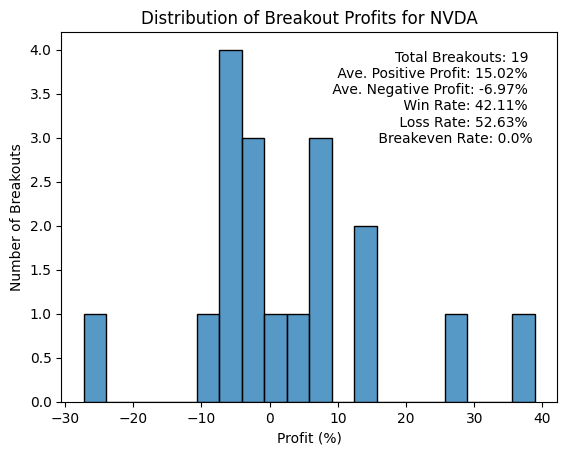

'Additional Info: The first breakout for NVDA was observed on 2019-09-05 while the most recent breakout was on 2024-01-08. The holding period for each breakout trade is maximum of 10 days.'

In [43]:
breakout_profitability('NVDA')

Retrieved 1257 days of historical prices for AMD


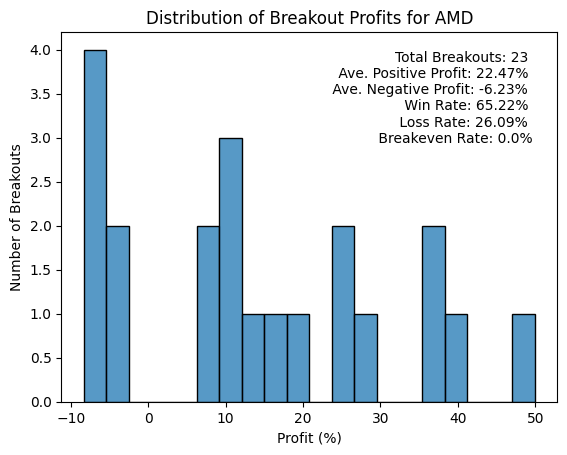

'Additional Info: The first breakout for AMD was observed on 2019-03-19 while the most recent breakout was on 2024-01-19. The holding period for each breakout trade is maximum of 10 days.'

In [44]:
breakout_profitability('AMD')